In [1]:
from scipy.sparse import csr_matrix
import pickle

from utils import *
from multi_threading import read_all_images, parallel_exponentiate_RMS, parallel_sum
from plotting import plot_SUM_or_RMS

# debugging = [True]
array_configs:configDict = dict(debugging=False, 
                  pickle_usage=True, 
                  tiff_amount_cutoff=None
                  )

### Functions

In [2]:
"""
Hello world
"""
# Mirror of sum_array_dense()
# Should create a dense sparse matrix output
@timer_decorator(array_configs)
def get_RMS_array_dense(tiff_path:str, array_configs:configDict) -> np.ndarray:
    """
    Read all images in the `tiff_path`, get `csr_matrix`. Calculate RMS. 
    
    Then convert them to dense.
    """
    pickle_usage = array_configs['pickle_usage']
    debugging = array_configs['debugging']
    
    image_arrays_csr = read_all_images(tiff_path, array_configs)
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')

    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            RMS_array = pickle.load(f)
        print('Loaded RMS_image_array.pkl')
    
    else:

        # squaring_start_time = time.time()
        # square = [img.power(2) for img in image_arrays]
        square = parallel_exponentiate_RMS(image_arrays_csr, 2)

        # squaring_end_time = time.time()
        # if debugging==True:
        #     print(f'Squaring time: {squaring_end_time - squaring_start_time:.1f} seconds. With {get_def_name()}')


        # adding_start_time = time.time()
        # RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)
        RMS_array_csr:csr_matrix = (parallel_sum(square) / len(square)).power(0.5)

        # adding_end_time = time.time()
        # if debugging==True:
        #     print(f'Adding time: {adding_end_time - adding_start_time:.1f} seconds. With {get_def_name()}')


        if debugging==True:
            # print(f'Total RMS_array elements: {RMS_array_csr.size}')    # 开什么玩笑，要吐了！应该直接取Image Dimension!
            _, image_width, image_length = get_tags_from_first_tiff(tiff_path)[:3]
            total_pixel_amount = image_width * image_length
            print(f'Total RMS_array elements: {total_pixel_amount}')
            print(f'Non-zero RMS_array elements: {RMS_array_csr.nnz}')
            print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_csr.nnz}')


        RMS_array:np.ndarray = RMS_array_csr.toarray()
        if pickle_usage==True:
            with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
                pickle.dump(RMS_array, f)

            # with open(f'{tiff_path}\\RMS_image_array_csr.pkl', 'wb') as f:
            #     pickle.dump(RMS_array_csr, f)

    return RMS_array


def get_camera_RMS(RMS_array:np.ndarray) -> float:
    """
    RMS_array is an array of pixel RMSs
    Calculating RMS of `RMS_array` is the same as calculating RMS for `img_arrays`
    """
    return np.sqrt(np.mean(RMS_array**2))


### Testing

Loaded RMS_image_array.pkl


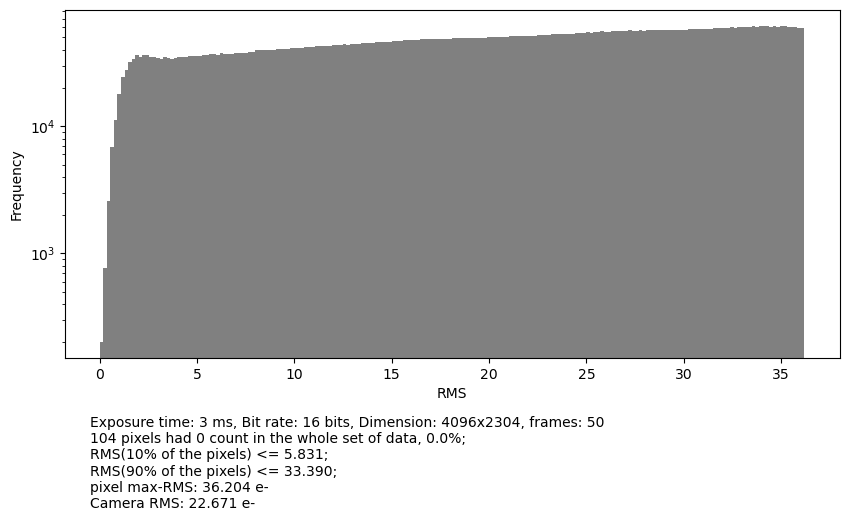

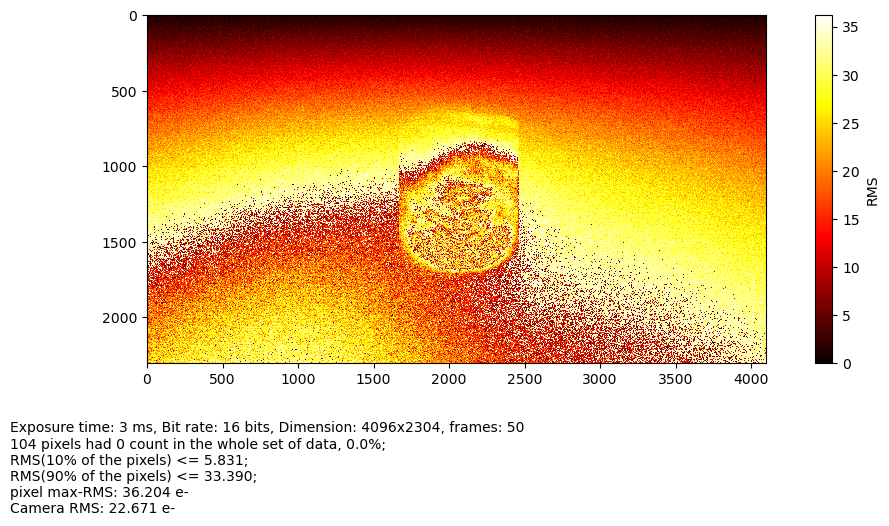

In [3]:
tiff_main_folder = 'C:\\LABDATA_office\\3.12 qCMOS'
# tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
# tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# tiff_path = tiff_main_folder + '\\full_5s_2000shots'
# tiff_path = tiff_main_folder + '\\full_5s_6000shots'
tiff_path = tiff_main_folder + '\\1024x1024_quick'
tiff_path = 'C:\\Users\\Soyo\\OneDrive\\LABDATA\\3.25 laser fluctuation with qCMOS\\qCMOS'


RMS_array = get_RMS_array_dense(tiff_path, array_configs)

plot_configs:plotDict = dict(
                            array_type = 'RMS', 
                            bin_amount = 200, 
                            heatmap_max = None, 
                            dpi = 100, 
                            save = False
                            )


plot_SUM_or_RMS(RMS_array, tiff_path, array_configs, plot_configs, 'bar')
plot_SUM_or_RMS(RMS_array, tiff_path, array_configs, plot_configs, 'heat')
# plot_SUM_or_RMS(RMS_array, tiff_path, array_configs, plot_type='heat', array_type='RMS', save=True)

In [4]:
image_arrays_csr = read_all_images(tiff_path, array_configs)

img_0 = image_arrays_csr[0]

In [5]:
print(RMS_array[1500, 1800])

2.3108440016582685


In [6]:
pixel_list = [-1]*len(image_arrays_csr)
for i in range(len(image_arrays_csr)):
    img = image_arrays_csr[i]
    element = img[1500, 1800]
    pixel_list[i] = element

assert all(i>0 for i in pixel_list)

print(pixel_list)

rms = np.sqrt(np.mean(np.array(pixel_list)**2))
print(rms)

[65, 75, 77, 81, 78, 82, 79, 51, 72, 75, 62, 69, 63, 81, 75, 67, 66, 75, 71, 63, 69, 71, 79, 71, 72, 74, 76, 71, 78, 89, 70, 60, 76, 65, 77, 63, 69, 71, 68, 90, 72, 65, 69, 65, 67, 65, 81, 83, 81, 69]
72.44459952266973


In [7]:
pixel_csr = [csr_matrix(i) for i in pixel_list]

square = parallel_exponentiate_RMS(pixel_csr, 2)
for i in range(len(square)):
    print(square[i])

SUM_14 = parallel_sum(square)
# print(SUM_14.todense())
# RMS_array_csr = (SUM_14 / len(square)).power(0.5)

  (0, 0)	4225
  (0, 0)	5625
  (0, 0)	5929
  (0, 0)	6561
  (0, 0)	6084
  (0, 0)	6724
  (0, 0)	6241
  (0, 0)	2601
  (0, 0)	5184
  (0, 0)	5625
  (0, 0)	3844
  (0, 0)	4761
  (0, 0)	3969
  (0, 0)	6561
  (0, 0)	5625
  (0, 0)	4489
  (0, 0)	4356
  (0, 0)	5625
  (0, 0)	5041
  (0, 0)	3969
  (0, 0)	4761
  (0, 0)	5041
  (0, 0)	6241
  (0, 0)	5041
  (0, 0)	5184
  (0, 0)	5476
  (0, 0)	5776
  (0, 0)	5041
  (0, 0)	6084
  (0, 0)	7921
  (0, 0)	4900
  (0, 0)	3600
  (0, 0)	5776
  (0, 0)	4225
  (0, 0)	5929
  (0, 0)	3969
  (0, 0)	4761
  (0, 0)	5041
  (0, 0)	4624
  (0, 0)	8100
  (0, 0)	5184
  (0, 0)	4225
  (0, 0)	4761
  (0, 0)	4225
  (0, 0)	4489
  (0, 0)	4225
  (0, 0)	6561
  (0, 0)	6889
  (0, 0)	6561
  (0, 0)	4761
sublist_sums:[<1x1 sparse matrix of type '<class 'numpy.uint16'>'
	with 1 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.uint16'>'
	with 1 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.uint16'>'
	with 1 stored

In [8]:
from functools import reduce
from operator import add

print(reduce(add, square).todense())
print(reduce(add, pixel_csr).todense())

print(f'sublist shapes: {[arr.shape for arr in square]}')

[[267]]
[[3603]]
sublist shapes: [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]


In [9]:
# tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# RMS_array_200ms = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# cameraRMS_200ms = get_camera_RMS(RMS_array_200ms)

# tiff_path = tiff_main_folder + '\\full_5s_6000shots'
# RMS_array_5000ms = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# cameraRMS_5000ms = get_camera_RMS(RMS_array_5000ms)

In [10]:
# # print(f'cameraRMS_200ms:{cameraRMS_200ms} e-')
# # print(f'cameraRMS_5000ms:{cameraRMS_5000ms} e-')
# dark_current = (cameraRMS_5000ms - cameraRMS_200ms) / 4.8
# print(f'Dark current:{dark_current} e-/(pixel*s)')